# 🧹 Notebook 2: Text Preprocessing

## 1. Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pavannn16/BERTopic-arXiv-Analysis/blob/main/notebooks/02_preprocessing.ipynb)

---

**Purpose:** Clean and normalize arXiv abstracts for topic modeling.

**Time:** ~1 minute

In [14]:
# ============================================================
# PROJECT PATH SETUP - Works on Colab Web, VS Code, or Local
# ============================================================

import os
from pathlib import Path

# Detect environment and set project path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_PATH = '/content/drive/MyDrive/BERTopic-arXiv-Analysis'
    print("✅ Running on Google Colab")
else:
    PROJECT_PATH = str(Path(os.getcwd()).parent) if 'notebooks' in os.getcwd() else os.getcwd()
    print("✅ Running locally")

print(f"📁 Project path: {PROJECT_PATH}")

Project path: /content
Path exists: True


In [15]:
# Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
from collections import Counter

print("Libraries imported!")

Libraries imported!


## 2. Load Raw Data

In [16]:
# Load raw data
raw_path = f"{PROJECT_PATH}/data/raw/arxiv_cs_ai_raw.csv"
df = pd.read_csv(raw_path)

print(f"Loaded {len(df)} papers")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 19900 papers
Columns: ['arxiv_id', 'title', 'abstract', 'authors', 'date', 'year_month', 'url', 'categories', 'primary_category', 'title_len', 'abstract_len']


,arxiv_id,title,abstract,authors,date,year_month,url,categories,primary_category,title_len,abstract_len
0,2512.01107v1,Foundation Priors,"Foundation models, and in particular large lan...",Sanjog Misra,2025-11-30,2025-11,http://arxiv.org/abs/2512.01107v1,"cs.AI, econ.EM, stat.ML",cs.AI,17,1571
1,2512.01105v1,Supporting Productivity Skill Development in C...,College students often face academic challenge...,"Himanshi Lalwani, Hanan Salam",2025-11-30,2025-11,http://arxiv.org/abs/2512.01105v1,"cs.RO, cs.AI, cs.HC",cs.RO,111,1334
2,2512.01099v1,Energy-Aware Data-Driven Model Selection in LL...,As modern artificial intelligence (AI) systems...,"Daria Smirnova, Hamid Nasiri, Marta Adamska, Z...",2025-11-30,2025-11,http://arxiv.org/abs/2512.01099v1,cs.AI,cs.AI,71,1071
3,2512.01097v1,Discriminative classification with generative ...,"We introduce Smart Bayes, a new classification...","Zachary Terner, Alexander Petersen, Yuedong Wang",2025-11-30,2025-11,http://arxiv.org/abs/2512.01097v1,"stat.ML, cs.AI, cs.LG, stat.CO, stat.ME",stat.ML,100,1072
4,2512.01095v1,CycliST: A Video Language Model Benchmark for ...,"We present CycliST, a novel benchmark dataset ...","Simon Kohaut, Daniel Ochs, Shun Zhang, Benedic...",2025-11-30,2025-11,http://arxiv.org/abs/2512.01095v1,"cs.CV, cs.AI, cs.LG",cs.CV,85,1589


## 3. Text Cleaning Functions

In [17]:
def clean_text(text):
    """
    Clean and normalize text from arXiv abstracts.
    
    Steps:
    1. Unicode normalization
    2. Remove LaTeX math expressions
    3. Remove LaTeX commands
    4. Remove URLs
    5. Remove arXiv references
    6. Remove common boilerplate phrases
    7. Normalize whitespace
    """
    if not isinstance(text, str):
        return ""
    
    # 1. Unicode normalization
    text = unicodedata.normalize("NFKC", text)
    
    # 2. Remove LaTeX math expressions
    text = re.sub(r'\$[^$]+\$', ' ', text)  # Inline math $...$
    text = re.sub(r'\\\[[^\]]+\\\]', ' ', text)  # Display math \[...\]
    text = re.sub(r'\\begin\{equation\}.*?\\end\{equation\}', ' ', text, flags=re.DOTALL)
    text = re.sub(r'\\begin\{align\}.*?\\end\{align\}', ' ', text, flags=re.DOTALL)
    
    # 3. Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', text)  # \command{...}
    text = re.sub(r'\\[a-zA-Z]+', '', text)  # \command
    text = re.sub(r'\{|\}', '', text)  # Stray braces
    
    # 4. Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    
    # 5. Remove arXiv references
    text = re.sub(r'arXiv:\d+\.\d+', '', text)
    
    # 6. Remove common boilerplate (start of abstract)
    boilerplate_patterns = [
        r'^in this paper,?\s*',
        r'^in this work,?\s*',
        r'^this paper presents\s*',
        r'^this work presents\s*',
        r'^we present\s*',
        r'^we propose\s*',
        r'^we introduce\s*',
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    
    # 7. Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text


# Test the cleaning function
test_text = """
In this paper, we propose a novel approach to neural network optimization.
Our method achieves $O(n^2)$ complexity using \\textbf{gradient descent}.
See our code at https://github.com/example/repo and arXiv:2301.12345.
"""

print("Original:")
print(test_text)
print("\nCleaned:")
print(clean_text(test_text))

Original:

In this paper, we propose a novel approach to neural network optimization.
Our method achieves $O(n^2)$ complexity using \textbf{gradient descent}.
See our code at https://github.com/example/repo and arXiv:2301.12345.


Cleaned:
In this paper, we propose a novel approach to neural network optimization. Our method achieves complexity using . See our code at and .


## 4. Apply Preprocessing

In [18]:
# Clean title and abstract
print("Cleaning text...")
df['title_clean'] = df['title'].apply(clean_text)
df['abstract_clean'] = df['abstract'].apply(clean_text)

# Combine title and abstract for topic modeling
# The title provides important keywords, abstract provides context
df['text'] = df['title_clean'] + ". " + df['abstract_clean']

print("Text cleaning complete!")
print(f"\nSample cleaned text:")
print(df['text'].iloc[0][:500])

Cleaning text...
Text cleaning complete!

Sample cleaned text:
Foundation Priors. Foundation models, and in particular large language models, can generate highly informative responses, prompting growing interest in using these ''synthetic'' outputs as data in empirical research and decision-making. This paper introduces the idea of a foundation prior, which shows that model-generated outputs are not as real observations, but draws from the foundation prior induced prior predictive distribution. As such synthetic data reflects both the model's learned patter


In [19]:
# Calculate text lengths
df['text_len'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("Text length statistics:")
print(df[['text_len', 'word_count']].describe())

Text length statistics:
           text_len    word_count
count  19900.000000  19900.000000
mean    1413.317688    187.931859
std      313.970005     42.329193
min       85.000000     12.000000
25%     1202.000000    159.000000
50%     1414.000000    187.000000
75%     1639.000000    217.000000
max     3508.000000    491.000000


## 5. Quality Filtering

In [20]:
# Filter out very short texts (likely incomplete or corrupted)
MIN_TEXT_LENGTH = 100
MIN_WORD_COUNT = 20

initial_count = len(df)

# Apply filters
df = df[df['text_len'] >= MIN_TEXT_LENGTH]
df = df[df['word_count'] >= MIN_WORD_COUNT]

# Remove duplicates by arxiv_id
df = df.drop_duplicates(subset=['arxiv_id'])

# Reset index
df = df.reset_index(drop=True)

removed_count = initial_count - len(df)
print(f"Removed {removed_count} documents (too short or duplicates)")
print(f"Remaining documents: {len(df)}")

Removed 2 documents (too short or duplicates)
Remaining documents: 19898


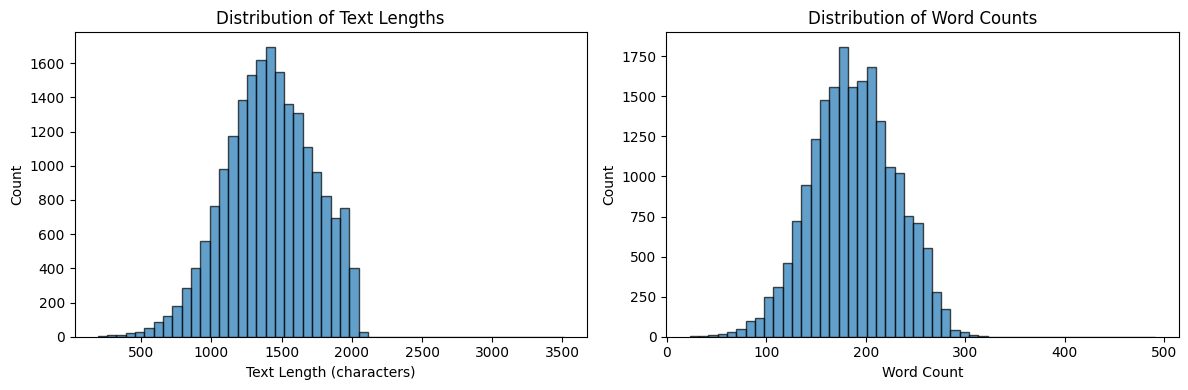

In [21]:
# Check text length distribution after filtering
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['text_len'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Text Lengths')

axes[1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Word Counts')

plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/text_length_distribution.png", dpi=150)
plt.show()

## 6. Exploratory Analysis

In [22]:
# Most common words (quick exploration)
from collections import Counter
import string

# Simple tokenization
all_words = []
for text in df['text']:
    words = text.lower().split()
    # Remove punctuation and short words
    words = [w.strip(string.punctuation) for w in words if len(w) > 2]
    all_words.extend(words)

# Count words
word_counts = Counter(all_words)

# Remove common stopwords for display
stopwords = {'the', 'and', 'for', 'are', 'with', 'that', 'this', 'from', 
             'can', 'our', 'has', 'have', 'been', 'which', 'their', 'more',
             'these', 'such', 'than', 'also', 'based', 'use', 'using'}

filtered_counts = {k: v for k, v in word_counts.items() if k not in stopwords}

print("Top 30 most common words (excluding stopwords):")
for word, count in Counter(filtered_counts).most_common(30):
    print(f"  {word}: {count}")

Top 30 most common words (excluding stopwords):
  models: 26907
  model: 18103
  data: 15163
  learning: 14845
  language: 13166
  framework: 13013
  performance: 12291
  reasoning: 12146
  llms: 11600
  while: 10995
  large: 10407
  across: 10354
  methods: 8714
  tasks: 8571
  training: 8297
  results: 7562
  propose: 7473
  through: 7332
  systems: 7131
  approach: 7121
  into: 6973
  both: 6690
  generation: 6672
  existing: 6615
  demonstrate: 6475
  however: 6417
  accuracy: 6247
  introduce: 5958
  method: 5786
  evaluation: 5771


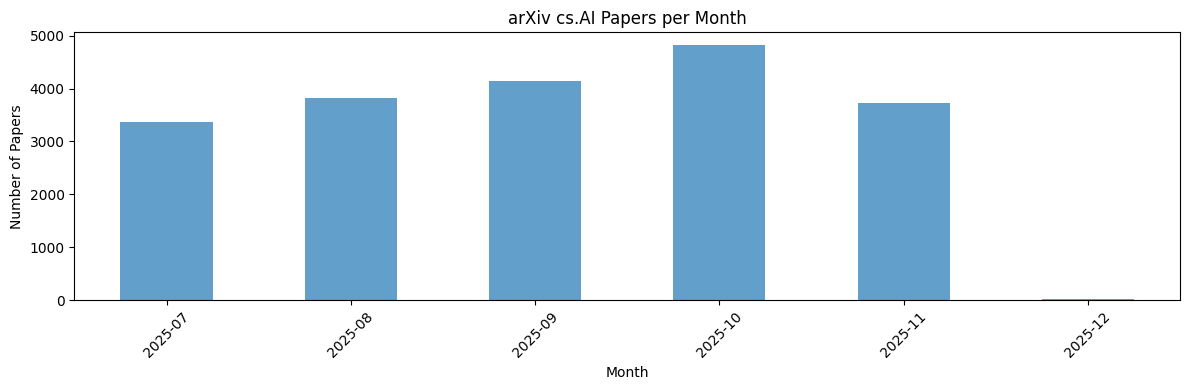

In [23]:
# Papers over time
papers_per_month = df['year_month'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
papers_per_month.plot(kind='bar', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Number of Papers')
plt.title('arXiv cs.AI Papers per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/papers_per_month.png", dpi=150)
plt.show()

## 7. Save Processed Data

In [24]:
# Select columns to save
columns_to_save = ['arxiv_id', 'title', 'abstract', 'title_clean', 'abstract_clean', 
                   'text', 'authors', 'date', 'year_month', 'url', 'categories']

df_save = df[columns_to_save].copy()

# Save processed data
processed_path = f"{PROJECT_PATH}/data/processed/arxiv_cs_ai_processed.csv"
df_save.to_csv(processed_path, index=False)

print(f"Saved {len(df_save)} processed documents to:")
print(f"  {processed_path}")

Saved 19898 processed documents to:
  /content/data/processed/arxiv_cs_ai_processed.csv


In [25]:
# Also save just the text column as a list (for BERTopic)
documents = df['text'].tolist()

import json
docs_path = f"{PROJECT_PATH}/data/processed/documents.json"
with open(docs_path, 'w') as f:
    json.dump(documents, f)

print(f"Saved {len(documents)} documents to {docs_path}")

Saved 19898 documents to /content/data/processed/documents.json


## Summary

This notebook has:
1. ✅ Loaded raw arXiv data
2. ✅ Applied text cleaning (LaTeX, URLs, boilerplate removal)
3. ✅ Combined title + abstract for richer topic representation
4. ✅ Filtered short/duplicate documents
5. ✅ Performed exploratory analysis
6. ✅ Saved processed data

**Next step:** Run `03_topic_modeling.ipynb` to train BERTopic model (requires GPU).